<a href="https://colab.research.google.com/github/WillMartin7/ggcnn_tf/blob/main/train_ggcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly keras

     |████████████████████████████████| 427.3MB 30kB/s 
     |████████████████████████████████| 4.0MB 36.5MB/s 
     |████████████████████████████████| 471kB 52.6MB/s 
     |████████████████████████████████| 4.0MB 40.8MB/s 
     |████████████████████████████████| 6.0MB 33.2MB/s 
     |████████████████████████████████| 3.9MB 48.4MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3

In [ ]:
!rm -r ggcnn_tf
!git clone https://github.com/WillMartin7/ggcnn_tf.git

rm: cannot remove 'ggcnn_tf': No such file or directory
Cloning into 'ggcnn_tf'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 190 (delta 88), reused 141 (delta 39), pack-reused 0
Receiving objects: 100% (190/190), 1.72 MiB | 30.43 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


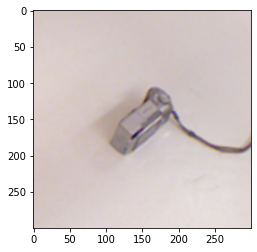

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

dataset_fn = '/content/drive/MyDrive/ggcnn_tf/dataset_210306_1745.hdf5'
f = h5py.File(dataset_fn, 'r')

img_ids = np.array(f['test/img_id'])
rgb_imgs = np.array(f['test/rgb'])
depth_imgs = np.array(f['test/depth_inpainted'])
bbs_all = np.array(f['test/bounding_boxes'])

img = rgb_imgs[150]

plot = plt.imshow(img)

In [ ]:
import os
from datetime import datetime

import h5py
import numpy as np

from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Input
from keras.models import Model

import tensorflow as tf


FILTER_SIZES = [
    [(9, 9), (5, 5), (3, 3)]
]

NO_FILTERS = [
    [32, 16, 8],
]

INPUT_DATASET = '/content/drive/MyDrive/ggcnn_tf/dataset_210306_1745.hdf5'

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)
gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
gpu_name

Fri Mar 12 18:11:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |    102MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

['name', 'Tesla T4']

In [ ]:
# Load the data.
f = h5py.File(INPUT_DATASET, 'r')

rgb_train = np.array(f['train/rgb'])
rgb_test = np.array(f['test/rgb'])

# depth_train = np.expand_dims(np.array(f['train/depth_inpainted']), -1)
point_train = np.expand_dims(np.array(f['train/grasp_points_img']), -1)
angle_train = np.array(f['train/angle_img'])
cos_train = np.expand_dims(np.cos(2*angle_train), -1)
sin_train = np.expand_dims(np.sin(2*angle_train), -1)
grasp_width_train = np.expand_dims(np.array(f['train/grasp_width']), -1)

# depth_test = np.expand_dims(np.array(f['test/depth_inpainted']), -1)
point_test = np.expand_dims(np.array(f['test/grasp_points_img']), -1)
angle_test = np.array(f['test/angle_img'])
cos_test = np.expand_dims(np.cos(2*angle_test), -1)
sin_test = np.expand_dims(np.sin(2*angle_test), -1)
grasp_width_test = np.expand_dims(np.array(f['test/grasp_width']), -1)

# Ground truth bounding boxes.
gt_bbs = np.array(f['test/bounding_boxes'])

f.close()

In [ ]:
# Set up the train and test data.

x_train = rgb_train

grasp_width_train = np.clip(grasp_width_train, 0, 150)/150.0
y_train = [point_train, cos_train, sin_train, grasp_width_train]

x_test = rgb_test

grasp_width_test = np.clip(grasp_width_test, 0, 150)/150.0
y_test = [point_test, cos_test, sin_test, grasp_width_test]

In [ ]:
for filter_sizes in FILTER_SIZES:
    for no_filters in NO_FILTERS:
        dt = datetime.now().strftime('%y%m%d_%H%M')

        NETWORK_NAME = "ggcnn_%s_%s_%s__%s_%s_%s" % (filter_sizes[0][0], filter_sizes[1][0], filter_sizes[2][0],
                                                     no_filters[0], no_filters[1], no_filters[2])
        NETWORK_NOTES = """
            Input: Inpainted depth, subtracted mean, in meters, with random rotations and zoom. 
            Output: q, cos(2theta), sin(2theta), grasp_width in pixels/150.
            Dataset: %s
            Filter Sizes: %s
            No Filters: %s
        """ % (
            INPUT_DATASET,
            repr(filter_sizes),
            repr(no_filters)
        )
        OUTPUT_FOLDER = 'data/networks/%s__%s/' % (dt, NETWORK_NAME)

        if not os.path.exists(OUTPUT_FOLDER):
            os.makedirs(OUTPUT_FOLDER)

        # Save the validation data so that it matches this network.
        np.save(os.path.join(OUTPUT_FOLDER, '_val_input'), x_test)

        # ====================================================================================================
        # Network

        input_layer = Input(shape=x_train.shape[1:])

        x = Conv2D(no_filters[0], kernel_size=filter_sizes[0], strides=(3, 3), padding='same', activation='relu')(input_layer)
        x = Conv2D(no_filters[1], kernel_size=filter_sizes[1], strides=(2, 2), padding='same', activation='relu')(x)
        encoded = Conv2D(no_filters[2], kernel_size=filter_sizes[2], strides=(2, 2), padding='same', activation='relu')(x)

        x = Conv2DTranspose(no_filters[2], kernel_size=filter_sizes[2], strides=(2, 2), padding='same', activation='relu')(encoded)
        x = Conv2DTranspose(no_filters[1], kernel_size=filter_sizes[1], strides=(2, 2), padding='same', activation='relu')(x)
        x = Conv2DTranspose(no_filters[0], kernel_size=filter_sizes[0], strides=(3, 3), padding='same', activation='relu')(x)

        # ===================================================================================================
        # Output layers

        pos_output = Conv2D(1, kernel_size=2, padding='same', activation='linear', name='pos_out')(x)
        cos_output = Conv2D(1, kernel_size=2, padding='same', activation='linear', name='cos_out')(x)
        sin_output = Conv2D(1, kernel_size=2, padding='same', activation='linear', name='sin_out')(x)
        width_output = Conv2D(1, kernel_size=2, padding='same', activation='linear', name='width_out')(x)

        # ===================================================================================================
        # And go!

        ae = Model(input_layer, [pos_output, cos_output, sin_output, width_output])
        ae.compile(optimizer='rmsprop', loss='mean_squared_error')

        ae.summary()

        with open(os.path.join(OUTPUT_FOLDER, '_description.txt'), 'w') as f:
            # Write description to file.
            f.write(NETWORK_NOTES)
            f.write('\n\n')
            ae.summary(print_fn=lambda q: f.write(q + '\n'))

        with open(os.path.join(OUTPUT_FOLDER, '_dataset.txt'), 'w') as f:
            # Write dataset name to file for future reference.
            f.write(INPUT_DATASET)

        tb_logdir = './data/tensorboard/%s_%s' % (dt, NETWORK_NAME)

        my_callbacks = [
            TensorBoard(log_dir=tb_logdir),
            ModelCheckpoint(os.path.join(OUTPUT_FOLDER, 'epoch_{epoch:02d}_model.hdf5'), period=1),
        ]

        ae.fit(x_train, y_train,
               batch_size=4,
               epochs=50,
               shuffle=True,
               callbacks=my_callbacks,
               validation_data=(x_test, y_test)
               )


  5/210 [..............................] - ETA: 5:06 - loss: 4.7498 - pos_out_loss: 0.3062 - cos_out_loss: 3.8462 - sin_out_loss: 0.3525 - width_out_loss: 0.2449

KeyboardInterrupt: ignored

In [ ]:
x_train.shape[1:]

(300, 300, 3)